/tmp/ipykernel_35390/3407869002.py:79: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spline = UnivariateSpline(E_vals, pi_vals[:, k],
/tmp/ipykernel_35390/3407869002.py:79: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spline = UnivariateSpline(E_vals, pi_vals[:, k],


Information Length Regression
Intercept: 0.9368562552990068
Coefficients [beta_eff, Q2n]: [-0.32551801  0.0057259 ]
R2: 0.043283519097150336


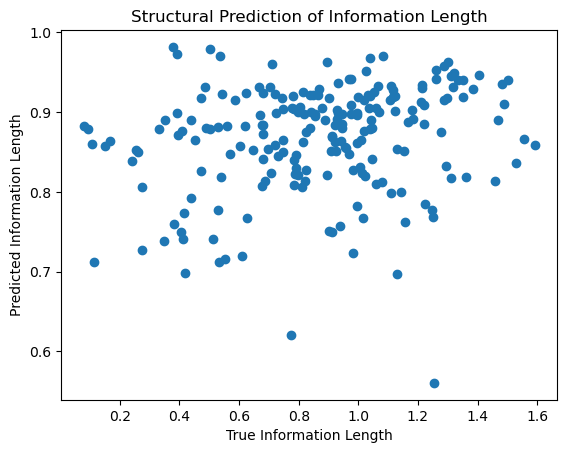

Information length analysis complete.


In [4]:
# ============================================================
# Information Length Analysis of MDN Regime Transition
# ============================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.integrate import simpson
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# ------------------------------------------------------------
# USER SETTINGS
# ------------------------------------------------------------

ENSEMBLE_DIR = "mdn_70_10_20_optimized/ensembles_fast"
N_COMPONENTS = 5
SMOOTHING_FACTOR = 1e-4   # spline smoothing parameter
MIN_POINTS = 5            # minimum energy points per reaction

# ------------------------------------------------------------
# LOAD DATA
# ------------------------------------------------------------
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)
switch_df = pd.read_csv("switch_df_final.csv")  # <-- change this

# ------------------------------------------------------------
# Helper: Load Ensemble-Averaged Regime Weights
# ------------------------------------------------------------

def load_regime_weights():
    """
    Load all ensemble seed regime outputs
    and compute mean π(E) for each reaction.
    """
    
    seed_dirs = [d for d in os.listdir(ENSEMBLE_DIR) if d.startswith("seed_")]
    
    all_data = []
    
    for seed in seed_dirs:
        path = os.path.join(ENSEMBLE_DIR, seed, "mdn_all_components.npz")
        data = np.load(path)
        pi = data["pi"]  # shape (N_total_points, 5)
        all_data.append(pi)
    
    pi_mean = np.mean(all_data, axis=0)
    
    return pi_mean

# ------------------------------------------------------------
# Compute Information Length for One Reaction
# ------------------------------------------------------------

def compute_information_length(E_vals, pi_vals):
    """
    Compute Fisher Information Length for one reaction.
    
    Parameters:
        E_vals: array of energies (sorted)
        pi_vals: array shape (N_points, 5)
        
    Returns:
        Information length L
    """
    
    if len(E_vals) < MIN_POINTS:
        return np.nan
    
    # Ensure no zeros
    pi_vals = np.clip(pi_vals, 1e-12, 1.0)
    
    # Spline smoothing for each component
    splines = []
    for k in range(N_COMPONENTS):
        spline = UnivariateSpline(E_vals, pi_vals[:, k],
                                  s=SMOOTHING_FACTOR)
        splines.append(spline)
    
    # Fine grid for integration
    E_fine = np.linspace(E_vals.min(), E_vals.max(), 300)
    
    v_squared = np.zeros_like(E_fine)
    
    for k in range(N_COMPONENTS):
        pi_k = splines[k](E_fine)
        dpi_k = splines[k].derivative()(E_fine)
        
        pi_k = np.clip(pi_k, 1e-12, None)
        
        v_squared += (dpi_k**2) / pi_k
    
    v = np.sqrt(v_squared)
    
    # Integrate using Simpson rule
    L = simpson(v, E_fine)
    
    return L

# ------------------------------------------------------------
# MAIN COMPUTATION
# ------------------------------------------------------------

pi_mean = load_regime_weights()

# Add π values to main dataframe
for k in range(N_COMPONENTS):
    df[f"pi_{k}"] = pi_mean[:, k]

results = []

for reaction in df["Reaction"].unique():
    
    sub = df[df["Reaction"] == reaction].copy()
    sub = sub.sort_values("E c.m.")
    
    E_vals = sub["E c.m."].values
    
    pi_vals = sub[[f"pi_{k}" for k in range(N_COMPONENTS)]].values
    
    L = compute_information_length(E_vals, pi_vals)
    
    results.append({
        "Reaction": reaction,
        "Information_Length": L
    })

info_df = pd.DataFrame(results)

# ------------------------------------------------------------
# Merge Structure Info
# ------------------------------------------------------------

structure_cols = ["Reaction", "beta_eff", "Q ( 2 n )"]
info_df = info_df.merge(
    switch_df[structure_cols],
    on="Reaction",
    how="left"
)

# ------------------------------------------------------------
# STRUCTURE REGRESSION
# ------------------------------------------------------------

X = info_df[["beta_eff", "Q ( 2 n )"]].values
y = info_df["Information_Length"].values

mask = np.isfinite(y)
X = X[mask]
y = y[mask]

model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

print("Information Length Regression")
print("Intercept:", model.intercept_)
print("Coefficients [beta_eff, Q2n]:", model.coef_)
print("R2:", r2_score(y, y_pred))

# ------------------------------------------------------------
# Plot Correlation
# ------------------------------------------------------------

plt.figure()
plt.scatter(y, y_pred)
plt.xlabel("True Information Length")
plt.ylabel("Predicted Information Length")
plt.title("Structural Prediction of Information Length")
plt.show()

# ------------------------------------------------------------
# Save Results
# ------------------------------------------------------------

info_df.to_csv("information_length_results.csv", index=False)

print("Information length analysis complete.")

In [5]:
barrier_df.to_csv("barrier_df.csv", index=False)

NameError: name 'barrier_df' is not defined

Number of reactions retained: 167
count    167.000000
mean       0.737208
std        0.275381
min        0.071071
25%        0.554796
50%        0.722651
75%        0.902799
max        1.784662
Name: Information_Length, dtype: float64


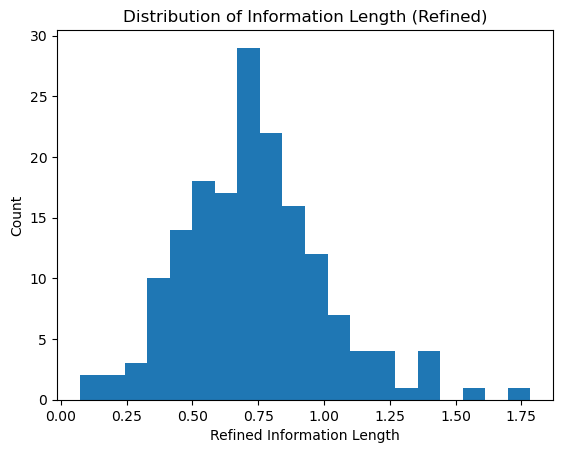

In [20]:
"""
Refined Information Length Calculation
---------------------------------------

Improvements:
1. Restrict integration window around Coulomb barrier
2. Use Savitzky-Golay filter for stable derivative
3. Filter low-quality reactions
4. Robust numerical integration

Author: <your name>
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.integrate import simpson

# ---------------------------
# CONFIGURATION
# ---------------------------

N_COMPONENTS = 5
ENERGY_WINDOW = (0.85, 1.15)   # integrate only near barrier
MIN_POINTS = 8                 # minimum energy points in window
PI_DOM_THRESHOLD = 0.4         # at least one regime must dominate
SAVGOL_WINDOW = 5              # must be odd
SAVGOL_POLY = 2

# ---------------------------
# LOAD DATA
# ---------------------------

# Original dataset
DRIVE_URL = "https://drive.google.com/uc?id=1PS0eB8dx8VMzVvxNUc6wBzsMRkEKJjWI"
df = pd.read_csv(DRIVE_URL)
# ---------------- Physics feature engineering ----------------
M_p = 938.272088; M_n = 939.565420; epsilon=1e-30; LN10=np.log(10.0)

def get_nucleon_mass(Z,A): return Z*M_p + (A-Z)*M_n

mass1 = df.apply(lambda r: get_nucleon_mass(r["Z1"], r["A1"]), axis=1).values
mass2 = df.apply(lambda r: get_nucleon_mass(r["Z2"], r["A2"]), axis=1).values

mu_MeVc2 = (mass1 * mass2) / (mass1 + mass2 + 1e-12)
Ecm = df["E c.m."].astype(float).values
v_over_c = np.sqrt(np.clip(2*Ecm/(mu_MeVc2+epsilon),0,np.inf))
e2_hbar_c = 1/137.035999

df["eta"] = (df["Z1"]*df["Z2"]) / (e2_hbar_c*(v_over_c+1e-16))

log10_sigma_exp = np.log10(np.clip(df["σ"],1e-30,np.inf))
log10_sigma_cal = np.log10(np.clip(df["σ cal"],1e-30,np.inf))
log10_Ecm = np.log10(np.clip(df["E c.m."],1e-30,np.inf))

log10_exp_term = (2*np.pi*df["eta"])/LN10

df["log10_S_exp"] = log10_sigma_exp + log10_Ecm + log10_exp_term
df["log10_S_cal"] = log10_sigma_cal + log10_Ecm + log10_exp_term
df["delta_log10_S"] = df["log10_S_exp"] - df["log10_S_cal"]

df["N1"] = df["A1"] - df["Z1"]
df["N2"] = df["A2"] - df["Z2"]
df["Z1Z2_over_Ecm"] = (df["Z1"]*df["Z2"]) / (df["E c.m."] + epsilon)

MAGIC = np.array([2,8,20,28,50,82,126])
def magic_dist(arr): return np.min(np.abs(arr[:,None] - MAGIC[None,:]),axis=1)

df["magic_dist_Z1"] = magic_dist(df["Z1"].values)
df["magic_dist_N1"] = magic_dist(df["N1"].values)
df["magic_dist_Z2"] = magic_dist(df["Z2"].values)
df["magic_dist_N2"] = magic_dist(df["N2"].values)
# Load barrier parameters
barrier_df = pd.read_csv("barrier_df.csv")

# Load ensemble-averaged regime weights
pi_df = pd.read_csv("pi_ensemble.csv")

# Merge everything
df = df.merge(barrier_df[["Reaction", "V_B"]], on="Reaction")
df = df.merge(pi_df, on=["Reaction", "E c.m."])

# ---------------------------
# INFORMATION LENGTH FUNCTION
# ---------------------------

def compute_information_length(E_vals, pi_vals):
    """
    Compute Fisher information length over restricted energy window.
    """

    # Ensure sorted by energy
    order = np.argsort(E_vals)
    E_vals = E_vals[order]
    pi_vals = pi_vals[order]

    # Compute derivatives using Savitzky-Golay
    dpi_dE = np.zeros_like(pi_vals)

    for k in range(pi_vals.shape[1]):

        # Need enough points for SG filter
        if len(E_vals) < SAVGOL_WINDOW:
            return np.nan

        # First smooth the curve
        smoothed = savgol_filter(pi_vals[:, k],
                                 window_length=SAVGOL_WINDOW,
                                 polyorder=SAVGOL_POLY)

        # Then derivative
        derivative = savgol_filter(pi_vals[:, k],
                                    window_length=SAVGOL_WINDOW,
                                    polyorder=SAVGOL_POLY,
                                    deriv=1,
                                    delta=np.mean(np.diff(E_vals)))

        dpi_dE[:, k] = derivative

    # Fisher speed
    eps = 1e-8
    v_squared = np.sum((dpi_dE ** 2) / (pi_vals + eps), axis=1)
    v = np.sqrt(v_squared)

    # Integrate
    L = simpson(v, E_vals)

    return abs(L)


# ---------------------------
# MAIN LOOP
# ---------------------------

results = []

for reaction in df["Reaction"].unique():

    sub = df[df["Reaction"] == reaction].copy()

    if len(sub) < MIN_POINTS:
        continue

    V_B = sub["V_B"].iloc[0]

    # Restrict energy window
    sub["x"] = sub["E c.m."] / V_B
    sub = sub[(sub["x"] >= ENERGY_WINDOW[0]) &
              (sub["x"] <= ENERGY_WINDOW[1])]

    if len(sub) < MIN_POINTS:
        continue

    # Extract regime weights
    pi_cols = [f"pi_{k}" for k in range(N_COMPONENTS)]
    pi_vals = sub[pi_cols].values

    # Ensure meaningful transition
    if np.max(pi_vals) < PI_DOM_THRESHOLD:
        continue

    E_vals = sub["E c.m."].values

    L = compute_information_length(E_vals, pi_vals)

    if not np.isnan(L):
        results.append({
            "Reaction": reaction,
            "Information_Length": L
        })

info_df = pd.DataFrame(results)

print("Number of reactions retained:", len(info_df))
print(info_df["Information_Length"].describe())

# Save results
info_df.to_csv("information_length_refined.csv", index=False)

# Plot distribution
plt.hist(info_df["Information_Length"], bins=20)
plt.xlabel("Refined Information Length")
plt.ylabel("Count")
plt.title("Distribution of Information Length (Refined)")
plt.show()

In [21]:
switch_df = pd.read_csv("switch_df_final.csv")
info_df = pd.read_csv("information_length_refined.csv")

merged = switch_df.merge(info_df, on="Reaction")

print(merged[["Information_Length", "beta_eff", "Q ( 2 n )"]].corr())

                    Information_Length  beta_eff  Q ( 2 n )
Information_Length            1.000000  0.021330   0.000672
beta_eff                      0.021330  1.000000  -0.041324
Q ( 2 n )                     0.000672 -0.041324   1.000000


In [22]:
# merged["Z1Z2_over_Ecm"] = (merged["Z1"] * merged["Z2"]) / merged["E c.m."]
print(merged[["Information_Length", "ħ ω"]].corr())
print(merged[["Information_Length", "Z1Z2_over_Ecm"]].corr())

                    Information_Length       ħ ω
Information_Length            1.000000  0.222696
ħ ω                           0.222696  1.000000


KeyError: "['Z1Z2_over_Ecm'] not in index"

In [23]:
print(merged.columns)

Index(['Reaction', 'E_switch', 'V_B', 'Q ( 2 n )', 'β P', 'β T', 'beta_eff',
       'x_switch', 'Delta_switch', 'DeltaV', 'ħ ω', 'DeltaV_over_hw', 'Z1',
       'A1', 'Z2', 'A2', 'N2', 'Information_Length'],
      dtype='str')


In [24]:
features_train = [
    'E c.m.', 'Z1', 'N1', 'A1',
    'Z2', 'N2', 'A2', 'Q ( 2 n )',
    'Z1Z2_over_Ecm',
    'magic_dist_Z1','magic_dist_N1','magic_dist_Z2','magic_dist_N2',
    'Z3','N3','A3','β P','β T','R B','ħ ω',
    'Projectile_Mass_Actual', 'Target_Mass_Actual', 'Compound_Nucleus_Mass_Actual',
    'Compound_Nucleus_Sp','Compound_Nucleus_Sn',
    'Projectile_Binding_Energy','Target_Binding_Energy',
    'Compound_Nucleus_Binding_Energy','Compound_Nucleus_S2n'
]
# Aggregate to reaction level
reaction_features = (
    df
    .groupby("Reaction")[features_train]
    .mean()
    .reset_index()
)

# Merge with information length
reaction_level_df = reaction_features.merge(
    info_df, on="Reaction"
)

print("Reaction-level shape:", reaction_level_df.shape)

Reaction-level shape: (167, 31)


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = reaction_level_df[features_train]
y = reaction_level_df["Information_Length"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=500,
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Test R²:", r2_score(y_test, y_pred))

Test R²: 0.32578905604197606


In [26]:
import pandas as pd

importance_df = pd.DataFrame({
    "Feature": features_train,
    "Importance": rf.feature_importances_
}).sort_values("Importance", ascending=False)

print(importance_df.head(10))

                            Feature  Importance
8                     Z1Z2_over_Ecm    0.143768
26            Target_Binding_Energy    0.130406
28             Compound_Nucleus_S2n    0.073070
7                         Q ( 2 n )    0.065655
23              Compound_Nucleus_Sp    0.049946
27  Compound_Nucleus_Binding_Energy    0.048767
19                              ħ ω    0.041422
16                              β P    0.040738
18                              R B    0.039930
0                            E c.m.    0.038959


In [27]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, y, cv=5, scoring="r2")
print("Cross-val R²:", scores.mean(), "+/-", scores.std())

Cross-val R²: -0.279114279660906 +/- 0.34307522679314917


In [28]:
# Count number of points inside barrier window
quality_df = []

for reaction in df["Reaction"].unique():

    sub = df[df["Reaction"] == reaction].copy()
    V_B = sub["V_B"].iloc[0]

    sub["x"] = sub["E c.m."] / V_B
    sub = sub[(sub["x"] >= 0.85) & (sub["x"] <= 1.15)]

    quality_df.append({
        "Reaction": reaction,
        "n_points_window": len(sub)
    })

quality_df = pd.DataFrame(quality_df)

# Merge with info_df
analysis_df = info_df.merge(quality_df, on="Reaction")

print(analysis_df["n_points_window"].describe())

count    167.000000
mean      16.065868
std        9.710966
min        8.000000
25%        9.000000
50%       12.000000
75%       20.000000
max       58.000000
Name: n_points_window, dtype: float64


In [29]:
high_density_df = analysis_df[analysis_df["n_points_window"] >= 10]
print("Retained:", len(high_density_df))

Retained: 123


In [30]:
clarity_list = []

for reaction in df["Reaction"].unique():

    sub = df[df["Reaction"] == reaction].copy()
    V_B = sub["V_B"].iloc[0]

    sub["x"] = sub["E c.m."] / V_B
    sub = sub[(sub["x"] >= 0.85) & (sub["x"] <= 1.15)]

    if len(sub) < 8:
        continue

    pi_cols = [f"pi_{k}" for k in range(N_COMPONENTS)]
    pi_vals = sub[pi_cols].values

    max_start = np.max(pi_vals[0])
    max_end = np.max(pi_vals[-1])

    clarity_list.append({
        "Reaction": reaction,
        "max_start": max_start,
        "max_end": max_end
    })

clarity_df = pd.DataFrame(clarity_list)

clarity_df["clear_transition"] = (
    (clarity_df["max_start"] > 0.8) &
    (clarity_df["max_end"] > 0.8)
)

print("Clear transitions:", clarity_df["clear_transition"].sum())

Clear transitions: 0


In [31]:
clear_reactions = clarity_df[clarity_df["clear_transition"]]["Reaction"]

refined_subset = reaction_level_df[
    reaction_level_df["Reaction"].isin(clear_reactions)
]

In [32]:
# reaction_level_df already contains:
#  - 29 aggregated features
#  - Information_Length

analysis_df = reaction_level_df.copy()

print(analysis_df.shape)

(167, 31)


In [33]:
from scipy.stats import pearsonr

features_to_test = [
    "Z1Z2_over_Ecm",
    "Target_Binding_Energy",
    "Compound_Nucleus_S2n",
    "Q ( 2 n )",
    "ħ ω"
]

for feat in features_to_test:
    r, p = pearsonr(analysis_df[feat], analysis_df["Information_Length"])
    print(f"{feat:30s}  r = {r:.3f}   p = {p:.4e}")

Z1Z2_over_Ecm                   r = 0.278   p = 2.7516e-04
Target_Binding_Energy           r = -0.220   p = 4.3675e-03
Compound_Nucleus_S2n            r = -0.227   p = 3.2196e-03
Q ( 2 n )                       r = 0.001   p = 9.9312e-01
ħ ω                             r = 0.223   p = 3.8199e-03


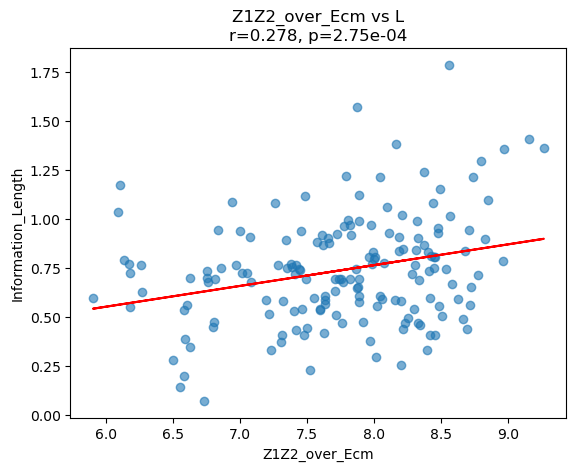

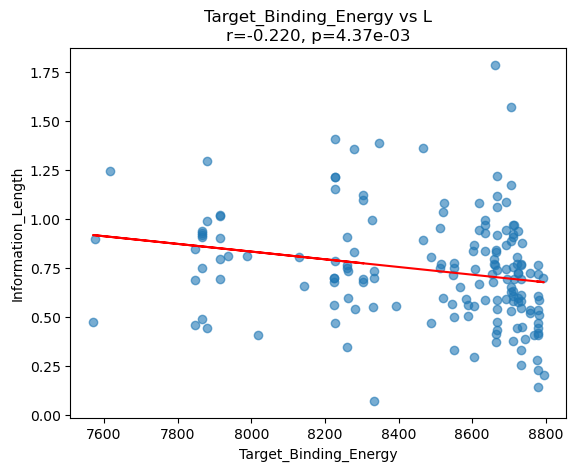

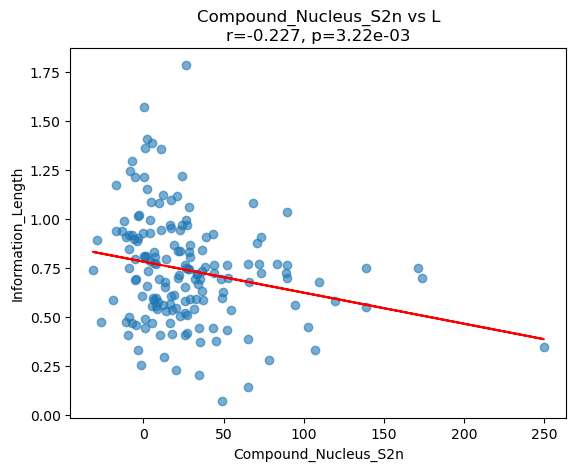

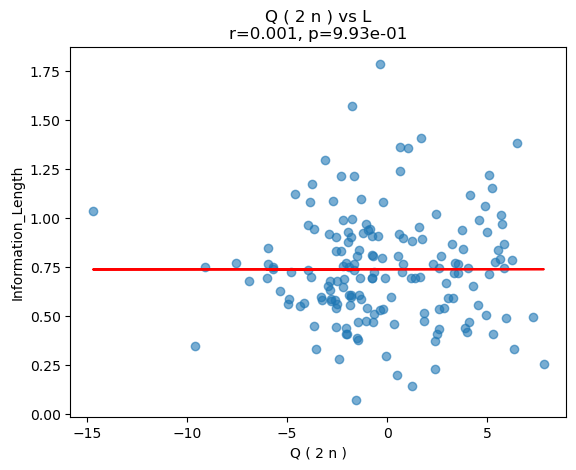

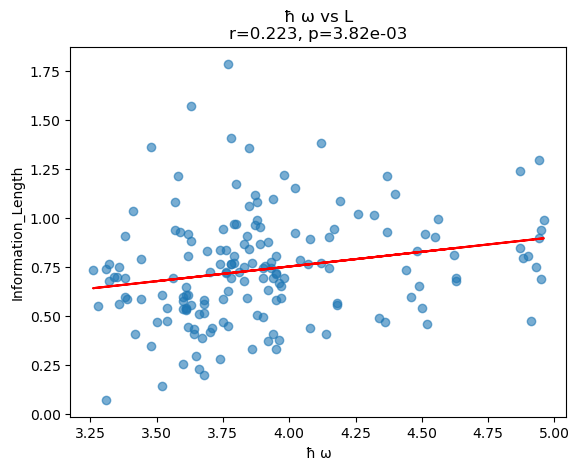

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_vs_L(feature):
    x = analysis_df[feature]
    y = analysis_df["Information_Length"]

    r, p = pearsonr(x, y)

    # Linear fit
    coeff = np.polyfit(x, y, 1)
    fit_line = np.poly1d(coeff)

    plt.figure()
    plt.scatter(x, y, alpha=0.6)
    plt.plot(x, fit_line(x), color='red')
    plt.xlabel(feature)
    plt.ylabel("Information_Length")
    plt.title(f"{feature} vs L\nr={r:.3f}, p={p:.2e}")
    plt.show()

for feat in features_to_test:
    plot_feature_vs_L(feat)

In [35]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Select features (remove E c.m. since L is reaction-level)
features_for_pca = [
    'Z1Z2_over_Ecm',
    'Target_Binding_Energy',
    'Compound_Nucleus_S2n',
    'ħ ω',
    'Q ( 2 n )',
    'R B'
]

X = analysis_df[features_for_pca].values
y = analysis_df["Information_Length"].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:")
print(pca.explained_variance_ratio_)

# Use first 3 PCs
X_reduced = X_pca[:, :3]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Test R²:", r2_score(y_test, y_pred))

Explained variance ratio:
[0.51303572 0.21732366 0.09250935 0.08390764 0.06467086 0.02855276]
Test R²: 0.16593451872540177


In [36]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(len(features_for_pca))],
    index=features_for_pca
)

print(loadings)

                            PC1       PC2       PC3       PC4       PC5  \
Z1Z2_over_Ecm          0.434660  0.282548 -0.018466  0.655083  0.462747   
Target_Binding_Energy -0.379186  0.538296 -0.381787  0.007968  0.350185   
Compound_Nucleus_S2n  -0.423028 -0.240374  0.679312  0.425215  0.165124   
ħ ω                    0.415939 -0.408203  0.055979 -0.390395  0.627107   
Q ( 2 n )              0.242921  0.637089  0.622166 -0.381935 -0.045151   
R B                    0.506280 -0.010582 -0.046999  0.302840 -0.490579   

                            PC6  
Z1Z2_over_Ecm         -0.296019  
Target_Binding_Energy  0.545894  
Compound_Nucleus_S2n   0.306151  
ħ ω                    0.334006  
Q ( 2 n )              0.010183  
R B                    0.639516  


In [37]:
width_results = []

for reaction in df["Reaction"].unique():
    sub = df[df["Reaction"] == reaction].copy()
    sub = sub.sort_values("E c.m.")
    
    if len(sub) < 8:
        continue
    
    # Get probability columns
    pi_cols = [f"pi_{k}" for k in range(N_COMPONENTS)]
    pi_vals = sub[pi_cols].values
    E_vals = sub["E c.m."].values
    
    # Find dominant regime at highest energy
    final_regime = np.argmax(pi_vals[-1])
    
    pi_final = pi_vals[:, final_regime]
    
    # Find where it crosses 0.1 and 0.9
    try:
        E_low = E_vals[np.where(pi_final > 0.1)[0][0]]
        E_high = E_vals[np.where(pi_final > 0.9)[0][0]]
        delta_E = E_high - E_low
    except:
        continue
    
    width_results.append({
        "Reaction": reaction,
        "Delta_E": delta_E
    })

width_df = pd.DataFrame(width_results)

In [39]:
merged_width = reaction_level_df.merge(width_df, on="Reactions")

for feat in features_for_pca:
    r, p = pearsonr(merged_width[feat], merged_width["Delta_E"])
    print(f"{feat:30s}  r = {r:.3f}   p = {p:.4e}")

KeyError: 'Reactions'

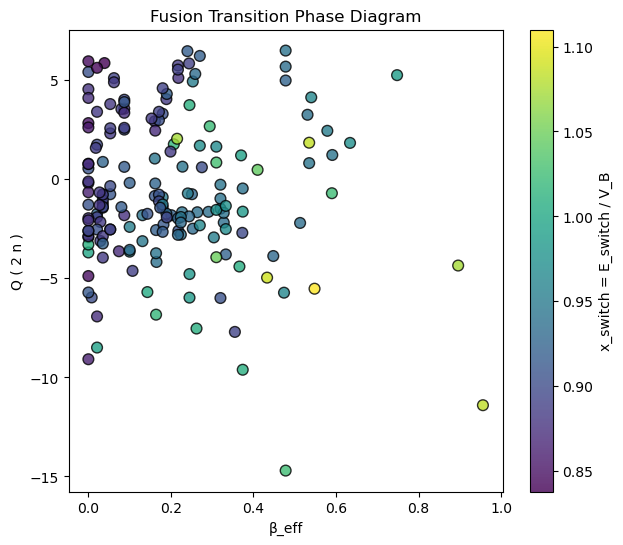

In [40]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(7,6))

sc = plt.scatter(
    switch_df["beta_eff"],
    switch_df["Q ( 2 n )"],
    c=switch_df["x_switch"],
    cmap="viridis",
    s=60,
    edgecolor='k',
    alpha=0.8
)

plt.xlabel("β_eff")
plt.ylabel("Q ( 2 n )")
plt.title("Fusion Transition Phase Diagram")
cbar = plt.colorbar(sc)
cbar.set_label("x_switch = E_switch / V_B")

plt.show()

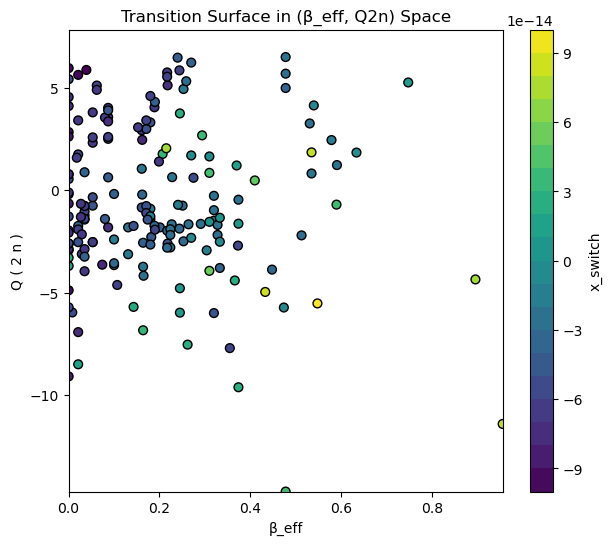

In [41]:
from scipy.interpolate import griddata

# Extract values
x = switch_df["beta_eff"].values
y = switch_df["Q ( 2 n )"].values
z = switch_df["x_switch"].values

# Create grid
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Xi, Yi = np.meshgrid(xi, yi)

Zi = griddata((x, y), z, (Xi, Yi), method='cubic')

plt.figure(figsize=(7,6))

cont = plt.contourf(Xi, Yi, Zi, levels=20, cmap="viridis")
plt.scatter(x, y, c=z, edgecolor='k', s=40)

plt.xlabel("β_eff")
plt.ylabel("Q ( 2 n )")
plt.title("Transition Surface in (β_eff, Q2n) Space")
cbar = plt.colorbar(cont)
cbar.set_label("x_switch")

plt.show()

In [42]:
# Fit simple plane
from sklearn.linear_model import LinearRegression

X_plane = switch_df[["beta_eff", "Q ( 2 n )"]]
y_plane = switch_df["x_switch"]

model = LinearRegression()
model.fit(X_plane, y_plane)

print("Plane coefficients:", model.coef_)
print("Intercept:", model.intercept_)
print("R²:", model.score(X_plane, y_plane))

ValueError: Input y contains NaN.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

cc_df = pd.read_csv(
    "ccfull_16O_144Sm.dat",
    delim_whitespace=True,
    header=None
)

cc_df.columns = ["E_cm", "sigma_CC", "D"]

print(cc_df.head())